In [281]:
import gym
from gym import Wrapper
from gym.spaces import Box, Discrete
from gym_minigrid.wrappers import FullyObsWrapper, RGBImgObsWrapper, ReseedWrapper
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
import skimage.measure

In [311]:
class OneHotWrapper(Wrapper):
    def __init__(self, env, seed=None):
        super().__init__(env)
        self.env = env
        self.observation_space = Box(0, 1, (361, ))
        self.action_space = Discrete(4)
        if seed is not None:
            random.seed(seed)
            if random.random() < 0.5:
                x = random.randint(1, 8)
            else:
                x = random.randint(10, 17)
            if random.random() < 0.5:
                y = random.randint(1, 8) 
            else:
                y = random.randint(10, 17)
            self.start_pos = np.array([x, y])
        else:
            self.start_pos = None

    def step(self, action):
        # 0 -- right, 1 -- down, 2 -- left, 3 -- up
        self.env.unwrapped.agent_dir = action
        _, reward, done, info = self.env.step(2)
        pos = self.env.unwrapped.agent_pos
        obs = self.get_obs(pos)
        return obs, reward, done, info

    def reset(self, **kwargs):
        self.env.reset()
        if self.start_pos is not None:
            self.env.unwrapped.agent_pos = self.start_pos
        pos = self.env.unwrapped.agent_pos
        return self.get_obs(pos)

    def get_obs(self, pos):
        obs = np.zeros(self.observation_space.shape)
        obs[pos[0] * 19 + pos[1]] = 1
        return obs

In [312]:
def onehot(idx, size):
    vec = np.zeros(size)
    vec[idx] = 1
    return vec

def twohot(idx, size):
    vec_1 = np.zeros(size)
    vec_2 = np.zeros(size)
    vec_1[idx[0]] = 1
    vec_2[idx[1]] = 1
    return np.concatenate([vec_1, vec_2])

def mask_grid(grid, blocks, mask_value=-100):
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            if [i,j] in blocks:
                grid[i,j] = mask_value
    grid = np.ma.masked_where(grid == mask_value, grid)
    return grid

In [313]:
class TabularSuccessorAgent(object):
    def __init__(self, state_size, action_size, learning_rate, gamma):
        self.state_size = state_size
        self.action_size = action_size
        
        # SR matrix
        self.M = np.stack([np.identity(state_size) for i in range(action_size)])
        
        # Reward weights
        self.w = np.zeros(state_size)
        self.learning_rate = learning_rate
        self.gamma = gamma
        
    def Q_estimates(self, state, goal=None):
        # Generate Q values for all actions.
        if goal is None:
            goal = self.w
        else:
            goal = onehot(state, goal)
        return np.matmul(self.M[:, state, :], goal)
    
    def sample_action(self, state, goal=None, epsilon=0.0):
        # Samples action using epsilon-greedy approach
        if np.random.uniform(0, 1) < epsilon:
            action = np.random.randint(self.action_size)
        else:
            Qs = self.Q_estimates(state, goal)
            action = np.argmax(Qs)
        return action
    
    def update_w(self, current_exp):
        # A simple update rule
        # exp: (state, action, next state, reward, done)
        state = current_exp[2]
        reward = current_exp[3]
        error = reward - self.w[state]
        self.w[state] += self.learning_rate * error        
        return error
    
    def update_sr(self, current_exp, next_exp):
        # SARSA TD learning rule
        # exp: (state, action, next state, reward, done)
        state = current_exp[0]
        action = current_exp[1]
        next_state = current_exp[2]
        next_action = next_exp[1]
        done = current_exp[4]
        I = onehot(state, self.state_size)
        if done:            
            td_error = (I + self.gamma * onehot(next_state, self.state_size) - self.M[action, state, :])
        else:
            td_error = (I + self.gamma * self.M[next_action, next_state, :] - self.M[action, state, :])
        self.M[action, state, :] += self.learning_rate * td_error
        return td_error
    

In [322]:
def get_env(env_seed, start_seed):
    env_id = 'MiniGrid-FourRooms-v0'
    env = gym.make(id=env_id)
    env.max_steps = max(train_episode_length, test_episode_length)
    env = OneHotWrapper(RGBImgObsWrapper(ReseedWrapper(env, seeds=[env_seed])), seed=start_seed)
    return env

In [318]:
def state_to_grid(state):
    obs = np.zeros(STATE_SIZE)
    obs[state] = 1
    return obs.reshape((GRID_SIZE, GRID_SIZE))

In [319]:
def print_occupancy(experiences, grid_size):
    occupancy_grid = np.zeros([grid_size, grid_size])
    for experience in experiences:
        occupancy_grid += state_to_grid(experience[0])
    occupancy_grid = np.sqrt(occupancy_grid).T
#     occupancy_grid = mask_grid(occupancy_grid, env.blocks)
    plt.imshow(occupancy_grid)

In [320]:
EPISODE_LENGTH = 500
STATE_SIZE = 361
ACTION_SIZE = 4
GRID_SIZE = 19

In [321]:
gamma = 0.99
lr = 5e-2
train_epsilon = 1.0
test_epsilon = 0.1

In [344]:
def run(agent, episodes, seeds, every=None):
    every = episodes // len(seeds)
    
    bounds = []
    experiences = []
    lifetime_td_errors = []

    test_bounds = []
    test_experiences = []
    test_lengths = []
    
    for i in range(episodes):
        if i % every == 0:
            env = get_env(0, seeds[i // every])
            agent.w = np.zeros(STATE_SIZE)
        state = env.reset().argmax()
        episodic_error = []
        for j in range(train_episode_length):
            action = agent.sample_action(state, epsilon=train_epsilon)
            state_next, reward, done, info = env.step(action)
            experiences.append([state, action, state_next.argmax(), reward, done])
            state = state_next.argmax()
            if (j > 1):
                td_sr = agent.update_sr(experiences[-2], experiences[-1])
                td_w = agent.update_w(experiences[-1])
                episodic_error.append(np.mean(np.abs(td_sr)))
            if done:
                td_sr = agent.update_sr(experiences[-1], experiences[-1])
                episodic_error.append(np.mean(np.abs(td_sr)))
                break
        lifetime_td_errors.append(np.mean(episodic_error))

        # Test phase
        state = env.reset().argmax()
        for j in range(test_episode_length):
            action = agent.sample_action(state, epsilon=test_epsilon)
            state_next, reward, done, info = env.step(action)
            test_experiences.append([state, action, state_next, reward])
            state = state_next.argmax()
            if done:
                break
        test_lengths.append(j)

        if i % 50 == 0:
            print('\rEpisode {}/{}, TD Error: {}, Test Lengths: {}'
                  .format(i, episodes, np.mean(lifetime_td_errors[-50:]), 
                          np.mean(test_lengths[-50:])))
            bounds.append(len(experiences))
            test_bounds.append(len(test_experiences))

    bounds.append(len(experiences))
    test_bounds.append(len(test_experiences))
    
    return bounds, experiences, lifetime_td_errors, test_bounds, test_experiences, test_lengths

In [345]:
def plot(lifetime_td_errors, test_lengths):
    fig = plt.figure(figsize=(10, 6))

    ax = fig.add_subplot(2, 2, 1)
    ax.plot(lifetime_td_errors)
    ax.set_title("TD Error")
    ax = fig.add_subplot(2, 2, 2)
    ax.plot(test_lengths)
    ax.set_title("Episode Lengths")

In [346]:
SR_agent = TabularSuccessorAgent(STATE_SIZE, ACTION_SIZE, lr, gamma)
episodes = 1000
seeds = [np.random.randint(10000) for i in range(0, episodes, 200)]

In [347]:
SR_training_data = run(SR_agent, episodes, seeds)

Episode 0/1000, TD Error: 0.0027422042318682666, Test Lengths: 499.0
Episode 50/1000, TD Error: 0.00413796316426166, Test Lengths: 499.0
Episode 100/1000, TD Error: 0.008133002256712844, Test Lengths: 499.0
Episode 150/1000, TD Error: 0.010781004225842663, Test Lengths: 499.0
Episode 200/1000, TD Error: 0.011349053662145217, Test Lengths: 499.0
Episode 250/1000, TD Error: 0.00828768789172031, Test Lengths: 332.34
Episode 300/1000, TD Error: 0.011307260323619886, Test Lengths: 15.66
Episode 350/1000, TD Error: 0.012755735997483135, Test Lengths: 16.0
Episode 400/1000, TD Error: 0.014093329224895923, Test Lengths: 15.54
Episode 450/1000, TD Error: 0.007314361739021629, Test Lengths: 7.74
Episode 500/1000, TD Error: 0.009327292059371406, Test Lengths: 7.76
Episode 550/1000, TD Error: 0.010595529164328835, Test Lengths: 7.84
Episode 600/1000, TD Error: 0.012631975288748772, Test Lengths: 17.46
Episode 650/1000, TD Error: 0.01221463577309284, Test Lengths: 40.32
Episode 700/1000, TD Error: 

In [348]:
import copy
SR_agent_w_old = copy.deepcopy(SR_agent.w)

In [349]:
SR_agent.w = np.zeros(STATE_SIZE)
SR_transfer_data = run(SR_agent, 200, [777])

Episode 0/200, TD Error: 0.018895474127286038, Test Lengths: 497.0
Episode 50/200, TD Error: 0.01851620134583747, Test Lengths: 23.02
Episode 100/200, TD Error: 0.019225493541827603, Test Lengths: 13.36
Episode 150/200, TD Error: 0.019863433082999295, Test Lengths: 13.54


In [350]:
raw_agent = TabularSuccessorAgent(STATE_SIZE, ACTION_SIZE, lr, gamma)

In [351]:
raw_agent_data = run(raw_agent, 200, [777])

Episode 0/200, TD Error: 0.0027485830112197822, Test Lengths: 499.0
Episode 50/200, TD Error: 0.004005719733350252, Test Lengths: 266.4
Episode 100/200, TD Error: 0.006669161715074458, Test Lengths: 107.74
Episode 150/200, TD Error: 0.00882490109676002, Test Lengths: 14.36


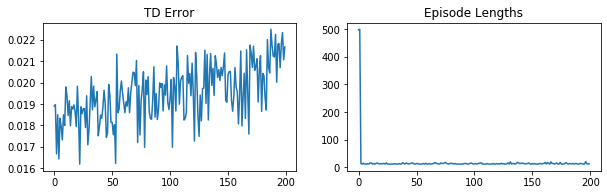

In [352]:
plot(SR_transfer_data[2], SR_transfer_data[5])

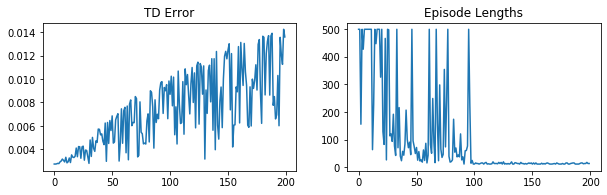

In [353]:
plot(raw_agent_data[2], raw_agent_data[5])

In [357]:
random.seed(777)
if random.random() < 0.5:
    x = random.randint(1, 8)
else:
    x = random.randint(10, 17)
if random.random() < 0.5:
    y = random.randint(1, 8) 
else:
    y = random.randint(10, 17)
start_pos = np.array([x, y])

In [358]:
start_pos

array([ 8, 14])

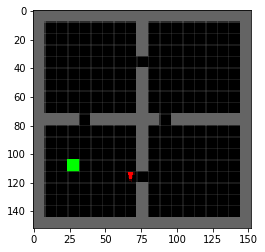

In [361]:
env_id = 'MiniGrid-FourRooms-v0'
env = gym.make(id=env_id)
img_env = RGBImgObsWrapper(ReseedWrapper(env, seeds=[0]))
img_env.unwrapped.agent_pos = start_pos
plt.imshow(img_env.step(5)[0])

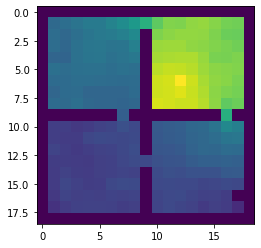

In [102]:
print_occupancy(experiences, GRID_SIZE)

In [103]:
test_bounds

[500, 25500, 35934, 36784, 37619, 38461, 39288, 40150]

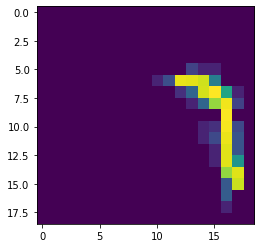

In [126]:
print_occupancy(test_experiences[39288:], GRID_SIZE)

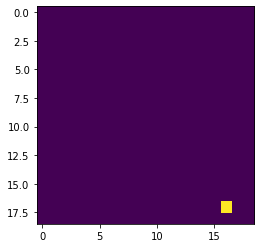

In [105]:
plt.imshow(agent.w.reshape(GRID_SIZE, GRID_SIZE))

In [106]:
averaged_SR = np.mean(agent.M, axis=0)

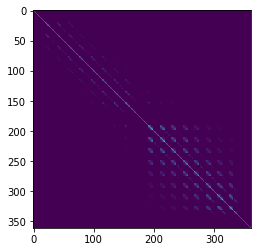

In [107]:
plt.imshow(averaged_SR)

In [108]:
grid_SR = averaged_SR.reshape(STATE_SIZE, GRID_SIZE, GRID_SIZE)

In [109]:
def get_idx(x, y):
    return x * GRID_SIZE + y

In [141]:
starting_SR = grid_SR[get_idx(16, 7)]
SR_dist = np.zeros((GRID_SIZE, GRID_SIZE))
for x in range(GRID_SIZE):
    for y in range(GRID_SIZE):
        SR_dist[(x, y)] = np.linalg.norm(grid_SR[get_idx(x, y)] - starting_SR)

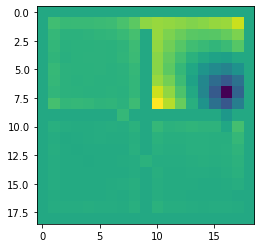

In [142]:
plt.imshow(SR_dist.T)

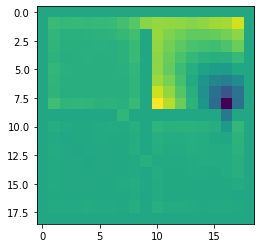

In [140]:
plt.imshow(SR_dist.T)

In [143]:
np.mean(SR_dist[1:9, 1:9])

4.50974036729521

In [144]:
np.mean(SR_dist[10:18, 10:18])

4.30425701236761

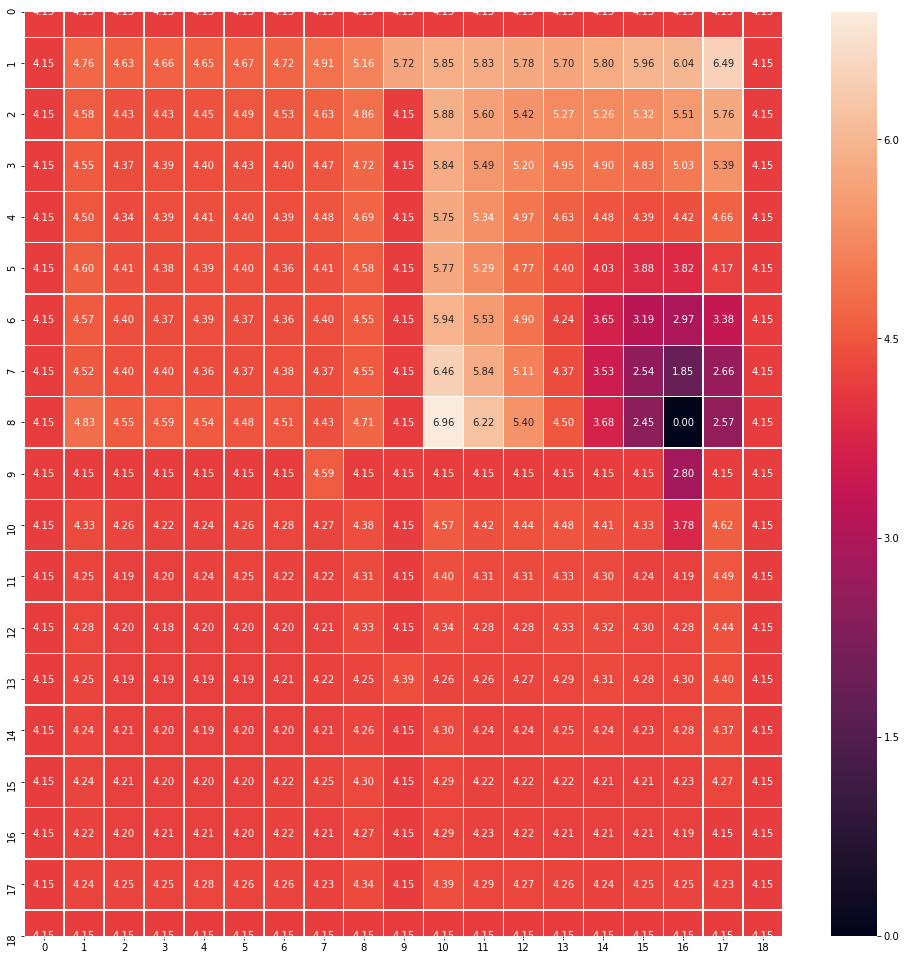

In [120]:
f, ax = plt.subplots(figsize=(17, 17))
sns.heatmap(SR_dist.T, annot=True, linewidth=0.5, fmt='0.2f')

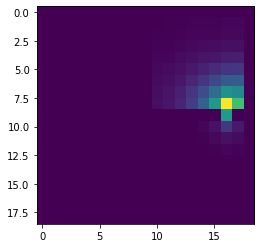

In [112]:
plt.imshow(grid_SR[get_idx(16, 8)].T)